# Jupyter notebook for plotting mesh convergence 
# Relative percentage error of simulations with different resolutions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py
from matplotlib import animation
from matplotlib import cm
import os,sys
sys.path.append('/Users/ajc/Core/PyScript')
import readdata as rd
import os
import geopy.distance
import utm
import seaborn as sns

In [2]:
infile ='/Users/ajc/Core/PreProcessing/ReactiveTransport/data/EFPC/'
outfile='/Users/ajc/Core/PostProcessing/ReactiveTransport/2021/Q2/EFPC/SIM_19/'

In [18]:
a_dx, dx_min = [250,10000], 100  # a_dx takes spatial resolution, and dx_min is the minimum length used for merging

In [19]:
#read high res number of cells (for visualization)
cellsmerged_d = np.loadtxt(os.path.join(infile,'reach_cells/vector_cells-10m_min%sm.dat'%dx_min),usecols=1,delimiter=',')
cellsmerged_d = np.array(cellsmerged_d,dtype=int)

def get_hres_cells(cellsmerged_d):
    csum = np.cumsum(cellsmerged_d)
    for c in csum:
        yield c

In [20]:
# High resolution data (centriods) for visulization (coarse data map onto this resolution)
mesh_hresC = dict()
cent_file = np.loadtxt(os.path.join(infile,'centroids/centriods_merged-10m_min%sm.dat'%dx_min),usecols=(0,1),delimiter=',')
mesh_hresC['x'] = np.array(cent_file[:,0],dtype=float)
mesh_hresC['y'] = np.array(cent_file[:,1],dtype=float)

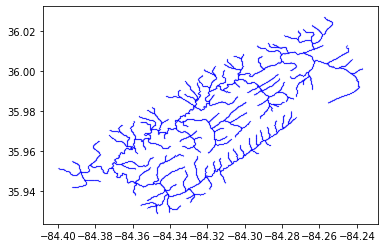

In [21]:
plt.scatter(mesh_hresC['x'],mesh_hresC['y'], s=0.01, c='b')

In [22]:
#Coarse scale simulation data
infile_sim = dict()
for dx in a_dx:
    sim = 'HE1_BGC_dx%sm_min%sm'%(dx,dx_min)
    sim_mesh= ''
    path='/Users/ajc/Core/simulations/production/streams/SIM_19/%s'%sim

    infile_sim[dx] = [os.path.join(path,'ats_vis_surface_data.h5'), os.path.join(path,'ats_vis_surface_mesh.h5') ]

In [23]:
# Coarse mesh
mesh = dict()
for k in infile_sim.keys():
    mesh[k] = rd.get_mesh_coords(infile_sim[k][1])

In [24]:
components = [(0,'DOM1'), (1,'O2(aq)'), (2,'NO3-'), (3,'HCO3-'),(4,'H+'), (5,'N2(aq)')]
def get_data(infile_s,comp):
    var = 'surface-total_component_concentration'
    dat = rd.GetSurfVarFromVis_All(infile_s[0],var,suffix='.cell.%s'%comp)[var]
    cycles = len(dat)
    return dat, cycles

In [25]:
SimData = dict()
cycles = 0
for k in infile_sim.keys():
    SimData[k], cycles = get_data(infile_sim[k],components[2][0])

In [26]:
# Get number of cells per reach in the coarse scale simulation
sim_cells_d = []
sim_cells = dict()
sim_bccells = dict()
reach_lengths = dict()
for k in infile_sim.keys():
    sim_cells_d = np.loadtxt(os.path.join(infile,'reach_cells/vector_cells-%sm_min%sm.dat'%(k,dx_min)),usecols=(0,2,3),delimiter=',')
    sim_cells[k] = np.array(sim_cells_d[:,0],dtype=int)
    sim_bccells[k] = np.array(sim_cells_d[:,1],dtype=int)
    reach_lengths[k] = np.array(sim_cells_d[:,2],dtype=int)

def get_cres_cells(key):
    csum = np.cumsum(sim_cells[key])
    for c in csum:
        yield c


-84.41876467666245 -84.21816574912654
35.91362694394487 36.04247054436494


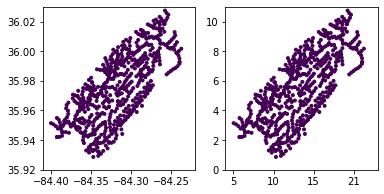

In [49]:
# get limits and convert UTM to meter
def get_limits():
    fig, ax = plt.subplots(1,2,figsize=(6,3))

    ax[0].scatter(mesh[a_dx[0]]['x'],mesh[a_dx[0]]['y'],marker=".",c=mesh[a_dx[0]]['z'])
    xmin, xmax = ax[0].get_xlim()
    ymin, ymax = ax[0].get_ylim()
    print(xmin,xmax)
    print(ymin,ymax)
    #EFPC
    X0 = [-84.41, -84.22]
    Y0 = [35.92, 36.03]
    
    ax[0].set_xlim(X0)
    ax[0].set_ylim(Y0)
    xmin, xmax = ax[0].get_xlim()
    ymin, ymax = ax[0].get_ylim()

    xx = geopy.distance.geodesic(xmin,xmax).km #+ 0.07
    yy = geopy.distance.geodesic(ymin,ymax).km #+ 0.455
    Xlabels = np.round(np.linspace(0,xx,5,dtype=int),4)
    Ylabels = np.round(np.linspace(0,yy,7,dtype=int),2)
    
    ax[1].scatter(mesh[a_dx[0]]['x'],mesh[a_dx[0]]['y'],marker=".",c=mesh[a_dx[0]]['z'])
    #l1,l2=538,545
    #print (len(SimData[250][100]),SimData[250][-1][l1:l2])
    #ax[1].scatter(mesh[a_dx[0]]['x'][l1:l2],mesh[a_dx[0]]['y'][l1:l2],marker=".",c=SimData[250][-1][l1:l2])
    ax[1].set_xticklabels(Xlabels)
    ax[1].set_yticklabels(Ylabels)
    ax[1].set_xlim(xmin,xmax)
    ax[1].set_ylim(ymin,ymax)
    #plt.gca().invert_xaxis()
    plt.show()
    return X0, Y0, Xlabels, Ylabels
    
X0, Y0, Xmeshlabels,Ymeshlabels = get_limits()

In [50]:
# map coarse data onto fine mesh. 
def get_mapped_data(coarseC, res):
    p_mesh_res = get_hres_cells(cellsmerged_d)
    p_mesh_sim = get_cres_cells(res)
    xprev1, xprev2 = 0, 0
    fineC, fineQ, fineQW = [], [], []
    fineC_NR = []
    coarseC_NR,coarseC_A = [], []
    N_source = []
    Qin_v, Qout_v, Qgw_v = [], [], []
    meshx = []
    meshy = []
    bc_count = 0
    count = 0
    for it1, it2 in zip(p_mesh_res,p_mesh_sim):
        l1 = len(coarseC[xprev2:it2])
        #l1 = 1 if l1 ==0 else l1
        
        l2 = int((it1 - xprev1)/(it2 -xprev2))
        C_temp = np.zeros((l1,l2))
        Q_temp = np.zeros((l1,l2))
        QW_temp = np.zeros((l1,l2))
        for i in range(l1):
            C_temp[i] = coarseC[xprev2:it2][i]            
        
        for c1,c2,c3 in zip(C_temp,Q_temp,QW_temp):
            fineC.append(c1)
            
        fineC1 = [c for x in fineC for c in x]
        
        r = (it1  - len(fineC1))
        for i1 in range(r):
            fineC.append([fineC[-1][0]])        
            count = count + 1
        xprev1 = it1
        xprev2 = it2
        bc_count = bc_count + 1
    fineC = [c for x in fineC for c in x]
    
    return fineC

In [53]:
import matplotlib.pyplot as mpl
mpl.rcParams['font.size'] = 13

-47.50877906243671 44.934025595632384


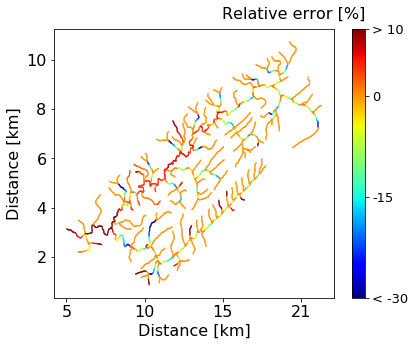

In [55]:
#%matplotlib qt
time = [np.round(t*3600/86400,2) for t in range(cycles)]
to_micro = 1e+6
start = cycles-1
end = start + 1
for k in range(start,cycles,1):
    var = components[2][1]
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    fineC = dict()
    for key in infile_sim.keys():
        d = SimData[key][k]
       
        d1 = np.array([r*1e-3*to_micro if r>0 else 1e-12 for r in d])
        fineC[key] = get_mapped_data(d1,res=key)
    
    r_lor, r_hor = 400, 50 
    
    #fineC1 = fineC[10000]#
    fineC1 = [(s2 - s1)/s1*100 for s1,s2 in zip(fineC[a_dx[0]], fineC[a_dx[1]])]
    print (min(fineC1), max(fineC1))
    l_min = [0, 1, -30, 49.9]
    l_max = [30,20,10,1, 500]
            
    
    sc = ax.scatter(mesh_hresC['x'],mesh_hresC['y'],marker=".",c=fineC1,s=.1, cmap='jet', vmin=l_min[2],vmax=l_max[2])#,norm=matplotlib.colors.LogNorm()) # mesh resolution

        
    cb = fig.colorbar(sc, ticks=[-30, -15, 0, 10])
    cb.ax.set_yticklabels(['< -30', '-15', '0', '> 10'])
    cb.ax.set_ylabel('Relative error [%]',labelpad=-115, y=1.08,rotation=0,fontsize=16)
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xticklabels(Xmeshlabels)
    ax.set_yticklabels(Ymeshlabels)
    ax.set_xlabel('Distance [km]',fontsize=16, fontweight='medium')
    ax.set_ylabel('Distance [km]',fontsize=16, fontweight='medium')
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout(h_pad=1)
    
    #plt.savefig(outfile + 'fig2D-dx250_SL-min100m-B.png',dpi=300)
    plt.savefig(outfile + 'fig2D-dx250_dx500-min100m-B-highres.jpg',dpi=2000)
    plt.show()
    count =1 + k
    if count == end:
        break
    plt.close()

